# **IRIS 붓꽃 분류: Using KNN**

## **1. 패키지 Import**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **2. 데이터 불러오기**

In [73]:
from sklearn import datasets

In [74]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## **3. 학습/검증 데이터 분리 및 특징 선택**

In [75]:
from sklearn.model_selection._split import train_test_split

In [76]:
use_columns = iris_df.columns[[0, 3]]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_df[use_columns], # 학습에 사용할 원하는 특징 선택
    iris.target,
    test_size = 0.3,
    random_state = 0,
    stratify = iris.target # 분류 할 클래스의 비율 조정
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(105, 2) (45, 2) (105,) (45,)


## **4. 스케일링**

> **스케일링을 하는 이유?**   
> * 특징 마다 단위가 상이함.   
> * 스케일링은 각 특징의 단위를 ```표준화``` 또는 ```정규화``` 함.

### **표준화: StandardScaler**

* 데이터의 특징을 각각 ```평균이 0```이고, ```분산이 1```인 ```가우시안 정규 분포```를 가진 값으로 변환

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
ss_scaler = StandardScaler()
X_train_ss = ss_scaler.fit_transform(X_train)
X_test_ss = ss_scaler.fit_transform(X_test)

### **정규화: MinMaxScaler**

* 각 특징을 크기를 ```0~1``` 또는 ```-1 ~ 1```의 크기로 변환해줌.
* (```-1 ~ 1```은 값에 음수가 존재할 경우)

In [80]:
from sklearn.preprocessing import MinMaxScaler

In [81]:
mms_scaler = MinMaxScaler()
X_train_mms = mms_scaler.fit_transform(X_train)
X_test_mms = mms_scaler.fit_transform(X_test)

## **5. KNN 모델 객체 생성**

* 데이터 선택: X_train/X_test, X_train_ss/X_test_ss

In [82]:
# X_train = X_train
# X_test = X_test

X_train = X_train_ss
X_test = X_test_ss

# X_train = X_train_mms
# X_test = X_test_mms

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

* **모델의 하이퍼 파라미터 불러오기**

In [85]:
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

* **하이퍼 파라미터 튜닝**

In [86]:
model = KNeighborsClassifier(
    n_neighbors = 5,      # 5, 10, 15, ... 등
    weights = 'uniform',   # 'uniform', 'distance' 등
)

In [87]:
model.fit(X_train, y_train)

KNeighborsClassifier()

* **GridSearch를 통한 하이퍼파라미터 튜닝**

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
param_grid = {
    "n_neighbors"      : [5, 10, 15],
    "weights"          : ["uniform", "distance"],
}

grid_model = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=2,   # K-fold
    refit=True)

In [90]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15],
                         'weights': ['uniform', 'distance']})

In [91]:
# GridSearch 결과 중, 최적 하이퍼파라미터 학습 모델 객체 반환
print(grid_model.best_params_)
best_model = grid_model.best_estimator_

{'n_neighbors': 10, 'weights': 'uniform'}


## **6. 모델 평가하기**

* 모델 선택: model, best_model

In [92]:
# model = model
model = best_model

In [93]:
from sklearn.metrics import accuracy_score

In [94]:
y_pred = model.predict(X_test)
print(f'분류 정확도: {accuracy_score(y_test, y_pred)}')

분류 정확도: 0.9777777777777777


In [95]:
from sklearn.metrics import classification_report

In [96]:
print(classification_report(y_pred, y_test, target_names=['setosa','versicolor','virginica']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.94      0.97        16
   virginica       0.93      1.00      0.97        14

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## **7. 시각화**

> **주의**
> * 2차원으로 시각화 하기 때문에 특징을 2개를 사용하여 학습한 모델만 사용할 것

In [97]:
from matplotlib.colors import ListedColormap

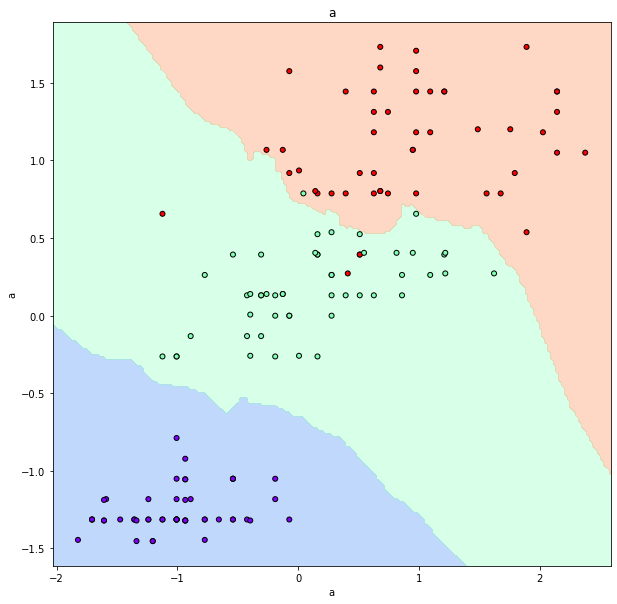

In [98]:
import numpy as np

plt.rcParams['figure.figsize'] = (10, 10)

def visualize_boundary(model, X, y, title, xlabel, ylabel):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k', zorder=3)
    ax.axis('tight')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,cmap='rainbow',zorder=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
visualize_boundary(model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]), 'a', 'a','a') 